In [1]:
import sys, os
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation
import glob
import pickle


In [2]:
data_path = "./ReadEvents/*"

all_files = sorted(glob.glob(data_path ))
# print(all_files)

In [3]:
from DoSpaceTrigger_DumpPickleData import ReadFile


Data = []  # List to hold data from all files

LoadPickle = True
PickleName = 'DoSpaceTrigger_Data.pkl'

if LoadPickle:
    if os.path.exists(PickleName):
        print(f"Pickle file {PickleName} exists, loading data from it.")
        with open(PickleName, 'rb') as f:
            Data = pickle.load(f)
        print(f"Loaded data from {PickleName}, total events: {len(Data)}")
    else:
        print(f"Pickle file {PickleName} does not exist, reading from raw files.")
else:
    for i,file in enumerate(all_files):
        print(f"Reading file {i+1}/{len(all_files)}: {file}", end='\r')
        ReadFile(file,Data)
    
    print(f"\nFinished reading files, total events: {len(Data)}")
    with open(PickleName, 'wb') as f:
        pickle.dump(Data, f)


Pickle file DoSpaceTrigger_Data.pkl exists, loading data from it.
Loaded data from DoSpaceTrigger_Data.pkl, total events: 3495


In [ ]:
# Redo the trigger using spatial analysis instead of time box analysis

def threshold_relaxation_coefficient(Guaranteed_Threshold,Neighbour_signals,coefficient_decay = 5.0):
    if type(Neighbour_signals) != np.ndarray: Neighbour_signals = np.array(Neighbour_signals)
    N_Neighbours = len(Neighbour_signals)
    # fractional_neighbour_signals = Neighbour_signals/Guaranteed_Threshold


    coefficient = np.exp(-coefficient_decay*np.sum(Neighbour_signals)/N_Neighbours)
    return max(0,coefficient)


def ReTriggerEvent(Event):
    # Extract the relevant data from the event

    N_pixels = Event['TotalPixels']

    PixelData = Event['PixelData']
    pix_Theta = PixelData['Theta']
    pix_Phi = PixelData['Phi']
    pix_Trace = PixelData['Trace']
    pix_RecTrigger = PixelData['RecTrigger']

    pix_MyyTrigger = np.zeros_like(pix_RecTrigger)

    trace_length = pix_Trace.shape[1]

    # First Construct the neighbour map
    neighbours_list = np.zeros((N_pixels,N_pixels), dtype=bool)
    for i_pix in range(N_pixels):
        for j_pix in range(N_pixels):
            if i_pix == j_pix: continue
            pix_distance = np.sqrt( (pix_Theta[i_pix]-pix_Theta[j_pix])**2 + (pix_Phi[i_pix]-pix_Phi[j_pix])**2 )
            if pix_distance < 2.0:  # degrees
                neighbours_list[i_pix,j_pix] = True
    

                
    # Now we can find the approximate trigger window from the RecTrigger
    triggered_positions = np.where(pix_RecTrigger)[1]
    if triggered_positions.size > 0:
        min_pos = np.min(triggered_positions[1])
        max_pos = np.max(triggered_positions[1])
    else:
        min_pos = 0
        max_pos = 99999
    min_pos = max(0,min_pos-3)
    max_pos = min(trace_length,max_pos+3)

    Norm_Signal_Array  = pix_Trace / np.std(pix_Trace[:,:200], axis=1, keepdims=True)

    GuaranteedThreshold = 5 # In units of std deviations

    # Now go over each time bin and ReTrigger
    for t in range(min_pos, max_pos+1):
        signals = Norm_Signal_Array[:,t]

        for i_pix in range(N_pixels):
            if signals[i_pix] > GuaranteedThreshold:
                pix_MyyTrigger[i_pix,t] = True
                continue

            neighbour_indices = np.where(neighbours_list[i_pix])[0]
            neighbour_signals = signals[neighbour_indices]
            neighbour_signals = np.clip(neighbour_signals, -GuaranteedThreshold, GuaranteedThreshold)

            relative_threshold = GuaranteedThreshold * threshold_relaxation_coefficient(GuaranteedThreshold, neighbour_signals)
            if signals[i_pix] > relative_threshold:
                pix_MyyTrigger[i_pix,t] = True
                
    
    # Now we must prune the trigger 

    # First we make sure that once triggered, a pixel stays triggered for at least 3 time bins
    for i_pix in range(N_pixels):
        triggered_times = np.where(pix_MyyTrigger[i_pix])[0]
        for t in triggered_times:
            trigger_bins = pix_MyyTrigger[i_pix, max(0,t-2):min(trace_length,t+3)]
            if len(trigger_bins) < 5: continue
            elif (np.sum(trigger_bins[0:3]) == 3) or (np.sum(trigger_bins[1:4]) == 3) or (np.sum(trigger_bins[2:5]) == 3): continue
            else: pix_MyyTrigger[i_pix, t] = False

    # Other Prunning Steps are not added yet

    Event['MyyTrigger'] = pix_MyyTrigger

    

In [10]:
# Now attempt to calculate My triggers for the events
for i,Event in enumerate(Data):
    print(f"ReTriggering event {i+1}/{len(Data)}", end='\r')
    ReTriggerEvent(Event)
print("\nFinished ReTriggering all events.")


/home/fedor-tairli/anaconda3/envs/Standard/lib/python3.12/site-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/tmp/ipykernel_7830/770341045.py:9: RuntimeWarning: invalid value encountered in scalar divide
  coefficient = np.exp(-5*np.sum(Neighbour_signals)/N_Neighbours)
/tmp/ipykernel_7830/770341045.py:67: RuntimeWarning: overflow encountered in scalar multiply
  relative_threshold = GuaranteedThreshold * threshold_relaxation_coefficient(GuaranteedThreshold, neighbour_signals)


/tmp/ipykernel_7830/770341045.py:9: RuntimeWarning: overflow encountered in exp
  coefficient = np.exp(-5*np.sum(Neighbour_signals)/N_Neighbours)


/home/fedor-tairli/anaconda3/envs/Standard/lib/python3.12/site-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


/tmp/ipykernel_7830/770341045.py:33: RuntimeWarning: overflow encountered in scalar power
  pix_distance = np.sqrt( (pix_Theta[i_pix]-pix_Theta[j_pix])**2 + (pix_Phi[i_pix]-pix_Phi[j_pix])**2 )


ReTriggering event 3495/3495
Finished ReTriggering all events.


[287 288 289 290 291 292 293 294 295 296 288 289 290 291 292 293 294 295
 296 290 291 292 293 294 295 296 297 298 291 292 293 294 295 296 297 298
 291 292 293 294 295 296 297 298 299 300]
Animating event Batch: 300000005, shower 3975, time bins 284 to 303


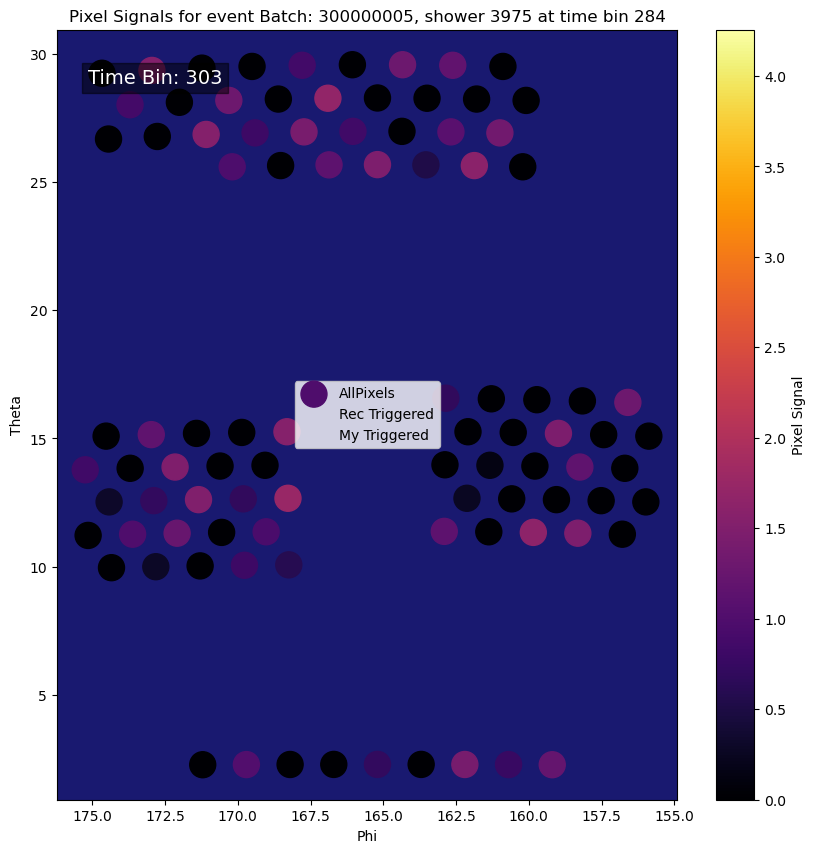

In [11]:
# Now lets plt this new trigger in the animation
# Make the Plot

EventIndex = 7
Event = Data[EventIndex]



set_std_norm_for_all = False
plot_log_scale = True


Pos_array = np.array( list( zip(Event['PixelData']['Phi'], Event['PixelData']['Theta']) ) )
Signal_array = Event['PixelData']['Trace']
Rec_Trigger_array = Event['PixelData']['RecTrigger']
My_Trigger_array = Event['MyyTrigger']
N_pixels_in_event = Event['TotalPixels']
trace_length = Signal_array.shape[1]

# Now we can find the approximate trigger window from the RecTrigger
triggered_positions = np.where(Rec_Trigger_array)[1]
print(triggered_positions)
if triggered_positions.size > 0:
    min_pos = np.min(triggered_positions)
    max_pos = np.max(triggered_positions)
else:
    min_pos = 0
    max_pos = 99999
min_pos = max(0,min_pos-3)
max_pos = min(trace_length,max_pos+3)

print(f"Animating event Batch: {Event['Batch']}, shower {Event['Shower']}, time bins {min_pos} to {max_pos}")

fig, ax = plt.subplots(figsize=(10, 10))
if set_std_norm_for_all:
    select_vmax = 5
    select_vmin = 0
elif plot_log_scale:
    select_vmax = np.log10(18000)
    select_vmin = 0
else:
    select_vmax = 500
    select_vmin = 0

scat = ax.scatter(Pos_array[:,0], Pos_array[:,1],
                    cmap='inferno',c = np.log10(np.clip(Signal_array[:,min_pos],a_min=1,a_max=None)),
                    s=350, label='AllPixels', alpha=1,
                    vmin = select_vmin, vmax = select_vmax)

# Plot red cross at triggered pixels at this time bin
rec_trigger_alpha = (Rec_Trigger_array[:,min_pos]*0.8).astype(float)
rec_triggered = ax.scatter(Pos_array[:,0], Pos_array[:,1], alpha = rec_trigger_alpha,
                            s=50, label='Rec Triggered', facecolors='none', c=['cyan']*N_pixels_in_event, linewidths=2,marker='x')

my_trigger_alpha = (My_Trigger_array[:,min_pos]).astype(float)
my_triggered = ax.scatter(Pos_array[:,0], Pos_array[:,1], alpha = my_trigger_alpha,
                            s=30, label='My Triggered', c = ['lime']*N_pixels_in_event, linewidths=2, marker='o')

# Bin Label Text
bin_text = ax.text(0.05, 0.95, f'Time Bin: {min_pos}', transform=ax.transAxes, fontsize=14,
                    verticalalignment='top', color='white', bbox=dict(facecolor='black', alpha=0.5))

ax.set_xlabel('Phi')
ax.set_ylabel('Theta')
ax.set_title(f'Pixel Signals for event Batch: {Event['Batch']}, shower {Event['Shower']} at time bin {min_pos}')
ax.set_facecolor('midnightblue')
plt.colorbar(scat, label='Pixel Signal')
plt.legend()

# Set Limits here if needed
# ax.set_xlim([-1.5,1.5])
# ax.set_ylim([-1.5,1.5])
ax.invert_xaxis()

# Construct the animation updates

def update(frame):
    if set_std_norm_for_all or not plot_log_scale : signals = Signal_array[:, frame]
    else : signals = signals = np.log10(np.clip(Signal_array[:,frame], a_min=1, a_max=None))
    
    scat.set_array(signals)
    bin_text.set_text(f'Time Bin: {frame}')

    rec_trigger_alpha = (Rec_Trigger_array[:,frame]*0.8).astype(float)
    rec_triggered.set_alpha(rec_trigger_alpha)
    my_trigger_alpha = (My_Trigger_array[:,frame]).astype(float)
    my_triggered.set_alpha(my_trigger_alpha)

    return scat, bin_text, rec_triggered

ani = FuncAnimation(
    fig, update, frames=range(min_pos, max_pos + 1),
    interval=500, blit=False, repeat=True
)
ani.save('trigger_animation.gif', writer='pillow', fps=2)
plt.show()

